In [25]:
import numpy as np
import matplotlib.pyplot as plt
from data import generate_data_second_order 
from models import GibbsSamplerLLFM
from evals import latent_features, latent_features_dominant_to_file
import matplotlib.pyplot as plt


In [ ]:
#Parameters
K=10            
alpha=1.1
sigma_w=2.0
sigma_b=1.0
#bias=[-5, -5, -5, -5]
mu_b = -1.0 #if sampling
n_iter=3000
burn=1000
n_subsample=1000
#ax_values = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50, 55, 60]
#ax_values = [8, 10, 12, 14, 16, 18]
ax_values = [0, 2, 4, 6, 8]
conds_list = [[1,0,0], [0,1,0], [0,0,1], [0,1,1]]
n_z_samples = 100
print(ax_values)

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50, 55, 60]


In [ ]:
posterior_probs_all = {str(conds): [] for conds in conds_list}
avg_features_list = []
dominant_features_list = []
for axnum in ax_values:

    # Generate dataset
    Data = generate_data_second_order(axnum=axnum)
    
    # Run Gibbs sampler
    sampler = GibbsSamplerLLFM(Data, K=K, n_iter=n_iter, alpha=alpha, sigma_w=sigma_w, mu_b=mu_b, sigma_b=sigma_b, burn=burn, n_subsample=n_subsample)
    sampler.run(verbose=False)
    sampler.get_posterior_samples()
    
    avg_features = latent_features(threshold=5, Z_post=sampler.good_samples_Z, W_post=sampler.good_samples_W, b_post=sampler.good_samples_b)
    avg_features_list.append(avg_features)
    dominant_features = latent_features_dominant_to_file('latent_features_dominant4.txt', threshold=5, Z_post=sampler.good_samples_Z, W_post=sampler.good_samples_W, b_post=sampler.good_samples_b, header=f'Number of A-X pairs: {axnum}.\n\n')
    dominant_features_list.append(dominant_features)

    # ---- Posterior predictive probabilities ----
    for conds in conds_list:
        p_y3 = sampler.posterior_predictive(
            cond_obs=conds, n_z_samples=n_z_samples
        )
        posterior_probs_all[str(conds)].append(p_y3)

Posterior grouping by number of active features

Number of samples with zero active features: 0/1000

Group with 2 active features:
  Number of posterior samples: 165/1000
  Average usage per feature (size-biased order):
[105.95151515  95.97575758]
  Average weights:
[[ 0.02983324 -9.49178154 -0.41134669  2.76897773]
 [ 3.26919941 -8.28600525 -4.69852145  1.93157205]]
  Average Bias:
[-0.21794472 -1.66931586 -0.21512175 -0.07060127]
--------------------------------------------------
Group with 3 active features:
  Number of posterior samples: 289/1000
  Average usage per feature (size-biased order):
[105.1799308   97.20415225  45.56401384]
  Average weights:
[[ 0.25299189 -8.62156438 -0.66505498  2.48905409]
 [ 2.86428108 -7.75297434 -4.13365687  1.79940855]
 [ 0.13571655 -3.34511999 -0.04443966  0.82227866]]
  Average Bias:
[-0.21238214 -1.5687685  -0.26793025 -0.08192353]
--------------------------------------------------
Group with 4 active features:
  Number of posterior samples: 2

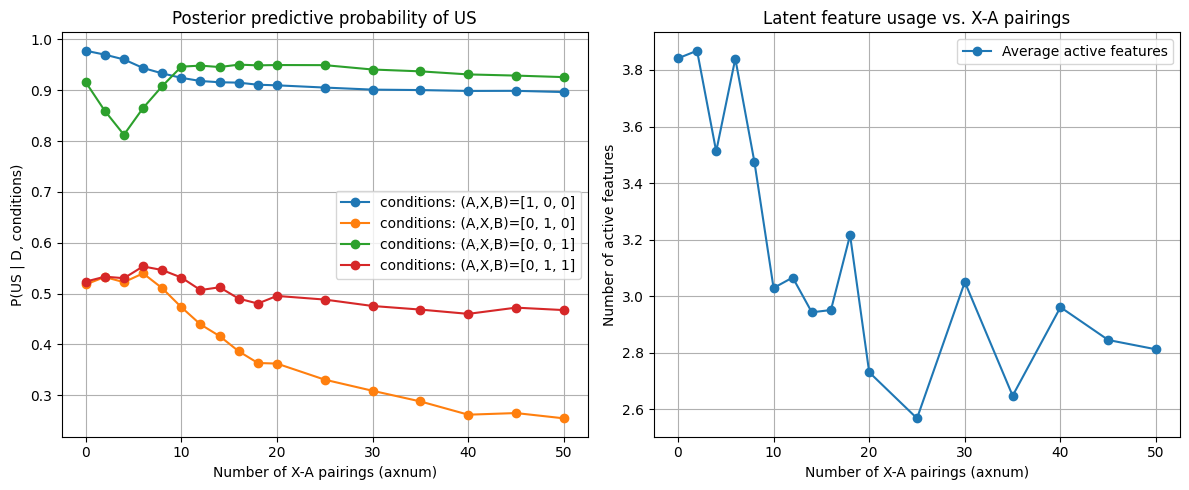

In [ ]:
import matplotlib.pyplot as plt

# ------------------------------
# Slice arrays to remove last two points
# ------------------------------
ax_plot = ax_values[:-2]
avg_features_plot = avg_features_list[:-2]

# ------------------------------
# Plot results
# ------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# ------------------------------
# Posterior predictive probabilities
# ------------------------------
for conds in conds_list:
    probs = posterior_probs_all[str(conds)][:-2]  # remove last two points
    axes[0].plot(
        ax_plot,
        probs,
        marker='o',
        label=f'conditions: (A,X,B)={conds}'
    )

axes[0].set_xlabel("Number of X-A pairings (axnum)")
axes[0].set_ylabel("P(US | D, conditions)")
axes[0].set_title("Posterior predictive probability of US")
axes[0].grid(True)
axes[0].legend()

# ------------------------------
# Latent feature statistics
# ------------------------------
axes[1].plot(
    ax_plot,
    avg_features_plot,
    marker='o',
    label="Average active features"
)

axes[1].set_xlabel("Number of X-A pairings (axnum)")
axes[1].set_ylabel("Number of active features")
axes[1].set_title("Latent feature usage vs. X-A pairings")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
#plt.savefig("posterior_predictive_and_features4.png", dpi=300)
plt.show()